# Gross-Vitells LEE for a bump hunt

## Preliminaries

Consider the case that we are trying to determine whether a reconstructed mass spectrum has evidence of a new resonant state.  That is, given some signal pdf $s(x;\boldsymbol{\theta})$ and background pdf $b(x;\mathbf{a})$ we would like to determine the amplitude, $A$, of the mixture model,

$$ 
f(x;\mathbf{a}, \mathbf{\theta}) = (1 - A)\,b(x;\mathbf{a}) + A\, s(x;\boldsymbol{\theta})
$$

The preferred figure of merit in such cases is the *profile likelihood ratio*,

$$
q_{0} = \frac{\mathcal{L}(A, \hat{\theta}, \hat{a})}{\mathcal{L}(A=0, \hat{a})}
$$

where the parameters have been optimized for the data.  This quantity has the nice property that is distributed according to a $\chi^{2}_{k}$ distribution where in our case the d.o.f. $k$ corresponds to the number of amplitude terms $A$ and is 1.  This is known as [Wilk's Theorem](https://en.wikipedia.org/wiki/Likelihood-ratio_test#Distribution:_Wilks.E2.80.99_theorem).


Frequently, such searches are undertaken with a specific model in mind that can constrain the search parameters, $\boldsymbol{\theta}$.  In this notebook I will consider the case that the search parameters are not well constrained, and we would like to adjust the probability to observe a resonance-like fluctuation given it could have appeared anywhere in our search space.

Typically, this problem is tackled by carrying out a very large number ($> 10^{6}$) pseudo-experiments which will inevitably be computationally expensive and in some cases infeasible.  The Gross-Vitells approach can be thought of as an extension to Wilk's Therorem where we will factor in the effects of the the unknown search parameters.  This is covered in detail in **citations**.  The important result is that we can represent the excursion probabilities as,

$$
\mathbb{P}[\max_{\theta \in \mathcal{M}} q(\theta) > u] \approx \mathbb{E}[\phi(A_{u})],
$$

where the excursion set of $q$ for some threshold $u$ is,

$$
A_{u} = \{\theta \in \mathcal{M}: q(\theta) > u\},
$$

and $\phi$ is the [Euler Characteristic](https://en.wikipedia.org/wiki/Euler_characteristic) of the excursion set.  To get some intuition about $\phi$, it can be thought of as the number of upcrossings of $q$ for some threshold $u$.

## Single dataset one dimensional LEE


In [1]:
# imports and configuration

%cd '/home/naodell/work/CMS/amumu'
%matplotlib notebook

import sys, pickle
from timeit import default_timer as timer

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2
from tqdm import tqdm_notebook

from nllfitter import Parameters, ScanParameters, Model, NLLFitter
import nllfitter.fit_tools as ft
import nllfitter.lookee as lee

xlimits = (12., 70.)
channel = '1b1f'

/home/naodell/work/CMS/amumu


I'm going to use the Sasha's dimuon dataset.  This sample has all of the 1b1f cuts already applied except the requirement that the dimuon mass be less than 70 GeV.

In [2]:
data, _ = ft.get_data('data/fit/events_pf_1b1f.csv', 'dimuon_mass')
data = data[data<70]
n_total = data.size

Next, define the background and signal models. For the background, a second-order Legendre polynomial is used.  For signal, a Gaussian will be used.  The bounds on $\mu$ and $\sigma$ should be set to correspond to the scan range.

In [4]:
bg_params = Parameters()
bg_params.add_many(
                   ('a1', 0., True, None, None, None),
                   ('a2', 0., True, None, None, None)
                  )

bg_model  = Model(ft.bg_pdf, bg_params)
bg_fitter = NLLFitter(bg_model, verbose=False)
bg_result = bg_fitter.fit(data)

sig_params = Parameters()
sig_params.add_many(
                    ('A'     , 0.01 , True , 0.0  , 1.  , None) ,
                    ('mu'    , 30.  , True , 16.  , 66. , None) ,
                    ('sigma' , 1.   , True , 0.45 , 3.  , None)
                   )
sig_params += bg_params.copy()
sig_model  = Model(ft.sig_pdf, sig_params)
sig_fitter = NLLFitter(sig_model, verbose=False)
sig_result = sig_fitter.fit(data)

Note that the signal model is the mixture of the background polynomial and the Gaussian.  In both cases, the models are fit to the data so that we can use the parameters for generating MC.  It will be important to know the value of the likelihood ratio so that we can later determine the corresponding global p value.

In [7]:
qmax = 2*(bg_model.calc_nll(data) - sig_model.calc_nll(data))

In order to determine the coefficients for the Gross-Vitells treatment, the search parameters will be scanned over a number of pseudo-datasets generated from the background-only model.  This is done by using a [simple acceptance-rejection sampler](https://github.com/naodell/amumu/blob/master/nllfitter/fit_tools.py#L146).  The number of toys necessary to get a good estimate is typically on the order of ten, but I will generate a 1000 for the sake of validation.

In [8]:
sims = ft.generator(bg_model.pdf, xlimits, ntoys=1000)

The scan parameters are defined in a class descriptively named ScanParamters.  This is convenient given a pair of values will need to be generated for each scan point and it will take care of that for us.  For the one dimensional case, this is overkill, but will help keep things clean when we go to the two dimensional case.

In [9]:
sigma_max = sig_params['sigma'].value
nscans = [30, 1]
bnds   = [(-16., 66.), (sigma_max, sigma_max)]
scan_params = ScanParameters(names  = ['mu', 'sigma'],
                             bounds = bnds,
                             nscans = nscans
                            )
# Clean this part up to make more sense for a 1D scan

Now we're ready to carry out the scans.  For each toy dataset, we will save the parameters that minimize the nll, the value of the EC for several excursion thresholds `u_0`.  I should mention that I used [Kyle Cranmer's notebook](https://github.com/cranmer/look-elsewhere-2d) on GV as a starting point.  For the most part, my framework is completely independent, but I did take his [code for calculating the EC](https://github.com/cranmer/look-elsewhere-2d).  It makes very nice use of numpy's image convolution modules.

In [10]:
phiscan   = []
qmaxscan  = []
u_0       = np.linspace(0.01, 30., 300)
for i, sim in tqdm_notebook(enumerate(sims), 
                            desc='Scanning', 
                            unit_scale=True, 
                            ncols=75, 
                            total=len(sims)):
    # fit background model
    bg_result = bg_fitter.fit(sim, calculate_corr)
    if bg_result.status == 0:
        nll_bg = bg_model.calc_nll(sim)
    else:
        continue

    # scan over signal parameters
    nllscan, params, dof = sig_fitter.scan(scan_params, sim)
    qscan = -2*(nllscan - nll_bg)
    qmaxscan.append(np.max(qscan))

    ### Calculate E.C. of the random field
    if qscan.size != np.prod(scan_params.nscans):
        continue
        
    qscan = np.array(qscan).reshape(scan_params.nscans)
    phiscan.append([lee.calculate_euler_characteristic((qscan > u) + 0.) 
                    for u in u_0])

# convert lists to arrays
phiscan     = np.array(phiscan)
qmaxscan    = np.array(qmaxscan)

nllfitter/nllfitter.py:65: RuntimeWarning: divide by zero encountered in true_divide
  corr_matrix = hinv/np.outer(sig, sig)
nllfitter/nllfitter.py:65: RuntimeWarning: invalid value encountered in true_divide
  corr_matrix = hinv/np.outer(sig, sig)
nllfitter/nllfitter.py:62: RuntimeWarning: invalid value encountered in sqrt
  sig = np.sqrt(hinv.diagonal())


LinAlgError: Singular matrix

Having completed the scans and calculated the corresponding EC, the coefficients for the EC densities can be determined.  This is done by carrying out a fit to the scan data.

In [30]:
param_init = [1.,]
param_bnds = [(0., np.inf), ]
kvals      = [1]
scales     = [0.5]
nvals      = lee.get_GV_coefficients(u_0, phiscan, param_init, param_bnds, kvals, scales)

Finally, calculate the relevant statistics and print the results,

In [31]:
### Calculate statistics and print ###
p_local  = 0.5*chi2.sf(qmax, 1)
z_local  = -norm.ppf(p_local)
p_global = lee.get_p_global(qmax, [1], nvals, [0.5])
z_global = -norm.ppf(p_global)

for i, n in enumerate(nvals.flatten()):
    print 'N{0} = {1:.2f}'.format(i+1, n)

print 'local p value       = {0:.3e}'.format(p_local)
print 'local significance  = {0:.2f}'.format(z_local)
print 'global p value      = {0:.3e}'.format(p_global)
print 'global significance = {0:.2f}'.format(z_global)
print 'trial factor        = {0:.2f}'.format(p_global/p_local)

N1 = 27.24
local p value       = 9.262e-06
local significance  = 4.28
global p value      = 4.617e-04
global significance = 3.31
trial factor        = 49.84


For the sake of validating this result we can check if our prediction from the Gross-Vitells formalism compares well with the distribution from the toy data.

<IPython.core.display.Javascript object>


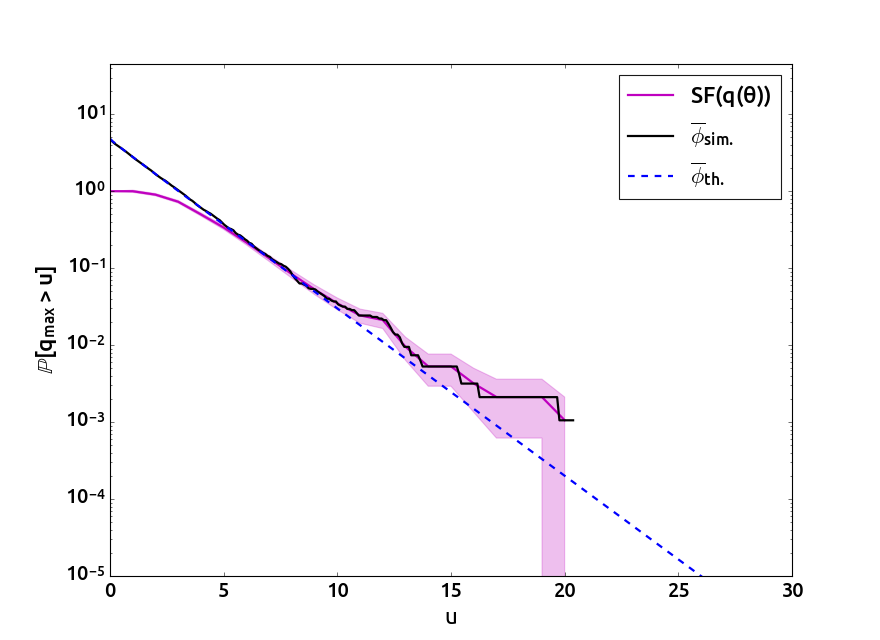

In [32]:
lee.gv_validation_plot(u_0, phiscan, qmaxscan, nvals, [1], [0.5], None)